# Preprocessing and Transformation

This notebook prepares the selected features for model training through transformations and encoding.

## What we will do:
1. Load selected features
2. Log transformation for target and skewed features
3. Encode categorical variables for different models
4. Feature scaling for linear models
5. Create model-specific datasets
6. Save final preprocessed datasets


In [51]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


## 1. Load Selected Features


In [52]:
# Load selected features dataset
df = pd.read_pickle('../../data/processed/df_selected_features.pkl')

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Separate features and target
target = 'SalePrice'
features = [col for col in df.columns if col != target]

print(f"Features: {len(features)}")
print(f"Target: {target}")

# Identify feature types
numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[features].select_dtypes(include=['category']).columns.tolist()

print(f"\nFeature types:")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
if categorical_features:
    print(f"Categorical features: {categorical_features}")

print(f"\nDataset info:")
print(df.info())


Dataset shape: (1408, 25)
Missing values: 0
Features: 24
Target: SalePrice

Feature types:
Numeric features: 24
Categorical features: 0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1408 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Quality_x_TotalSF  1408 non-null   float64
 1   Garage_x_Quality   1408 non-null   float64
 2   Bath_x_Area        1408 non-null   float64
 3   GrLivArea          1408 non-null   int64  
 4   GarageArea         1408 non-null   int64  
 5   YearBuilt          1408 non-null   int64  
 6   FullBath           1408 non-null   int64  
 7   EffectiveAge       1408 non-null   int64  
 8   Fireplaces         1408 non-null   int64  
 9   MasVnrArea         1408 non-null   float64
 10  TotRmsAbvGrd       1408 non-null   int64  
 11  HouseAge           1408 non-null   int64  
 12  GarageCars         1408 non-null   int64  
 13  TotalSF            140

## 2. Log Transformation


In [53]:
# Apply log transformation
print("=== LOG TRANSFORMATION ===")

# Create a copy for transformation
df_transformed = df.copy()

# 1. Transform target variable (SalePrice)
print("Transforming target variable (SalePrice)...")
df_transformed[target] = np.log1p(df_transformed[target])

# 2. Identify skewed numeric features
print("\nIdentifying skewed numeric features...")
skewness_threshold = 0.75

skewed_features = []
for feature in numeric_features:
    skewness = abs(df[feature].skew())
    if skewness > skewness_threshold:
        skewed_features.append((feature, skewness))

skewed_features.sort(key=lambda x: x[1], reverse=True)

print(f"Features with skewness > {skewness_threshold}:")
for feature, skew_value in skewed_features:
    print(f"  {feature}: {skew_value:.3f}")

# 3. Store original data for visualization before transformation
df_original_features = df.copy()

# 4. Apply per-feature optimal transformation
print(f"\nApplying per-feature optimal transformation to {len(skewed_features)} skewed features...")

from sklearn.preprocessing import PowerTransformer

def winsorize_top(s: pd.Series, q: float = 0.995) -> pd.Series:
    cap = s.quantile(q)
    return np.minimum(s, cap)

def transform_candidates(s: pd.Series) -> dict:
    out = {'none': s}
    s_min = s.min()
    shift = 1 - s_min if s_min <= 0 else 0
    # Careful with log/sqrt for non-positive
    out['log1p'] = np.log1p(s + shift)
    out['sqrt'] = np.sqrt(s + shift)
    out['cbrt'] = np.cbrt(s)
    # Yeo-Johnson handles zeros/negatives
    try:
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        out['yeojohnson'] = pd.Series(pt.fit_transform(s.values.reshape(-1, 1)).ravel(), index=s.index)
    except Exception:
        pass
    return out

def pick_best_transform(s: pd.Series, min_improve: float = 0.10):
    candidates = transform_candidates(s)
    skews = {name: abs(val.skew()) for name, val in candidates.items() if np.isfinite(val).all()}
    # Fallback
    if not skews:
        return 'none', s
    best_name = min(skews, key=skews.get)
    base = abs(s.skew())
    best = skews[best_name]
    # Apply only if improves at least min_improve fraction
    if base > 0 and best <= (1 - min_improve) * base:
        return best_name, candidates[best_name]
    else:
        return 'none', s

chosen_transforms = {}

for feature, original_skew in skewed_features:
    series = df_transformed[feature].copy()
    # Mild winsorization to stabilize extreme tails
    series = winsorize_top(series, q=0.995)
    method, transformed = pick_best_transform(series, min_improve=0.10)
    df_transformed[feature] = transformed
    chosen_transforms[feature] = {
        'method': method,
        'before_skew': float(original_skew),
        'after_skew': float(transformed.skew())
    }

print("✓ Per-feature transformation applied")

# Show a summary for all skewed features
print("\nSkewed features transformation summary:")
for feature, original_skew in skewed_features:
    meta = chosen_transforms.get(feature, {})
    print(f"  {feature}: {meta.get('method','none')} | {meta.get('before_skew',original_skew):.3f} → {meta.get('after_skew',df_transformed[feature].skew()):.3f}")


# Visualization moved to the next cell

print(f"\nTransformation summary:")
print(f"Target transformed: {target}")
print(f"Skewed features transformed: {len(skewed_features)}")


=== LOG TRANSFORMATION ===
Transforming target variable (SalePrice)...

Identifying skewed numeric features...
Features with skewness > 0.75:
  MasVnrArea: 2.610
  OpenPorchSF: 2.251
  TotalPorchSF: 1.051
  Bath_x_Area: 1.010
  Quality_x_Area: 0.958
  Quality_x_TotalSF: 0.918
  GrLivArea: 0.761
  1stFlrSF: 0.755

Applying per-feature optimal transformation to 8 skewed features...
✓ Per-feature transformation applied

Skewed features transformation summary:
  MasVnrArea: yeojohnson | 2.610 → 0.428
  OpenPorchSF: yeojohnson | 2.251 → -0.008
  TotalPorchSF: sqrt | 1.051 → -0.240
  Bath_x_Area: yeojohnson | 1.010 → -0.007
  Quality_x_Area: yeojohnson | 0.958 → -0.010
  Quality_x_TotalSF: yeojohnson | 0.918 → 0.001
  GrLivArea: yeojohnson | 0.761 → -0.004
  1stFlrSF: yeojohnson | 0.755 → -0.001

Transformation summary:
Target transformed: SalePrice
Skewed features transformed: 8


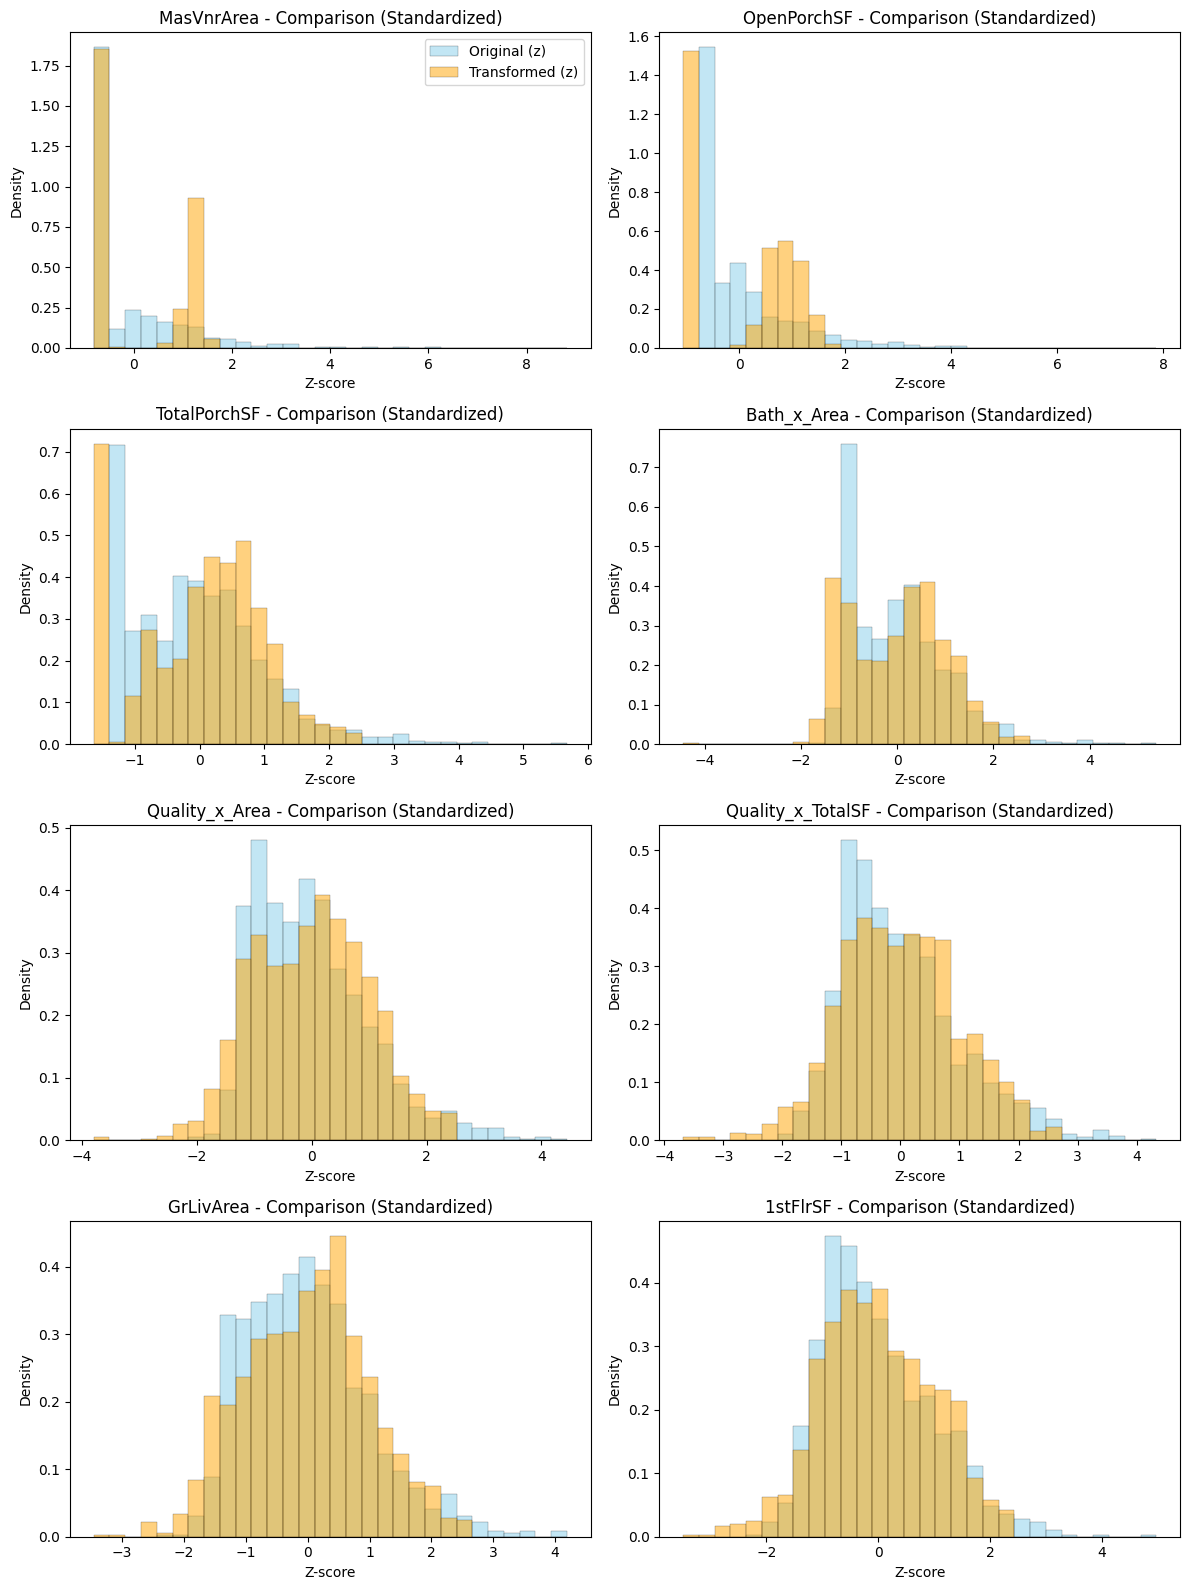

In [54]:
# Visualize transformation effect (grid: 2 plots per row)
import numpy as np
import matplotlib.pyplot as plt
import math

if skewed_features:
    features_to_plot = [feat[0] for feat in skewed_features]
    n = len(features_to_plot)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
    if nrows == 1:
        axes = np.array(axes).reshape(1, -1)

    for idx, feature in enumerate(features_to_plot):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        original_data = df_original_features[feature]
        transformed_data = df_transformed[feature]

        # Standardized overlay to compare shapes without scale issues
        o_z = (original_data - original_data.mean()) / (original_data.std() + 1e-9)
        t_z = (transformed_data - transformed_data.mean()) / (transformed_data.std() + 1e-9)
        bins = np.histogram_bin_edges(np.r_[o_z.values, t_z.values], bins=30)

        ax.hist(o_z, bins=bins, density=True, alpha=0.5, label='Original (z)', color='skyblue', edgecolor='black', linewidth=0.3)
        ax.hist(t_z, bins=bins, density=True, alpha=0.5, label='Transformed (z)', color='orange', edgecolor='black', linewidth=0.3)
        ax.set_title(f'{feature} - Comparison (Standardized)')
        ax.set_xlabel('Z-score'); ax.set_ylabel('Density')
        if idx == 0:
            ax.legend()

    # Hide any unused subplots
    total_axes = nrows * ncols
    for j in range(n, total_axes):
        r, c = divmod(j, ncols)
        fig.delaxes(axes[r, c])

    plt.tight_layout(); plt.show()
else:
    print('No skewed features to visualize.')


## 3. Encode Categorical Variables


In [55]:
# Encode categorical variables
print("=== CATEGORICAL ENCODING ===")

if categorical_features:
    print(f"Encoding {len(categorical_features)} categorical features...")
    
    # Create datasets for different models
    # 1. For Linear/Ridge models: OneHot encoding
    df_linear = df_transformed.copy()
    
    # 2. For Random Forest: Label encoding  
    df_rf = df_transformed.copy()
    
    # OneHot encoding for Linear/Ridge
    print("\nOneHot encoding for Linear/Ridge models...")
    encoded_cols = []
    
    for col in categorical_features:
        # Get dummies and add to dataframe
        dummies = pd.get_dummies(df_linear[col], prefix=col)
        df_linear = pd.concat([df_linear, dummies], axis=1)
        df_linear.drop(col, axis=1, inplace=True)
        encoded_cols.extend(dummies.columns.tolist())
    
    print(f"  Created {len(encoded_cols)} dummy variables")
    print(f"  New shape: {df_linear.shape}")
    
    # Label encoding for Random Forest
    print("\nLabel encoding for Random Forest...")
    le_dict = {}
    
    for col in categorical_features:
        le = LabelEncoder()
        df_rf[col] = le.fit_transform(df_rf[col].astype(str))
        le_dict[col] = le
    
    print(f"  Encoded {len(categorical_features)} categorical features")
    print(f"  Shape remains: {df_rf.shape}")
    
    # Update feature lists
    linear_features = [col for col in df_linear.columns if col != target]
    rf_features = [col for col in df_rf.columns if col != target]
    
    print(f"\nFeature counts:")
    print(f"  Linear/Ridge features: {len(linear_features)}")
    print(f"  Random Forest features: {len(rf_features)}")
    
else:
    print("No categorical features to encode")
    df_linear = df_transformed.copy()
    df_rf = df_transformed.copy()
    linear_features = features.copy()
    rf_features = features.copy()


=== CATEGORICAL ENCODING ===
No categorical features to encode


## 4. Feature Scaling


In [56]:
# Feature scaling
print("=== FEATURE SCALING ===")

# Scale features for Linear/Ridge models (required)
print("Scaling features for Linear/Ridge models...")

scaler = StandardScaler()
df_linear_scaled = df_linear.copy()

# Scale only the feature columns, not the target
X_linear_scaled = scaler.fit_transform(df_linear[linear_features])
df_linear_scaled[linear_features] = X_linear_scaled

print(f"  Scaled {len(linear_features)} features using StandardScaler")
print(f"  Target variable kept unchanged")

# Random Forest doesn't need scaling
print("\nRandom Forest dataset: No scaling needed")
df_rf_final = df_rf.copy()

print(f"  Random Forest features: {len(rf_features)}")

# Verify scaling results
print(f"\nScaling verification (Linear/Ridge dataset):")
print(f"  Feature means after scaling: {df_linear_scaled[linear_features].mean().abs().max():.6f}")
print(f"  Feature std after scaling: {df_linear_scaled[linear_features].std().abs().max():.6f}")

if df_linear_scaled[linear_features].mean().abs().max() < 1e-10 and abs(df_linear_scaled[linear_features].std().abs().max() - 1.0) < 1e-10:
    print("  ✓ Scaling successful (mean ≈ 0, std ≈ 1)")
else:
    print("  ⚠️ Scaling may have issues")


=== FEATURE SCALING ===
Scaling features for Linear/Ridge models...
  Scaled 24 features using StandardScaler
  Target variable kept unchanged

Random Forest dataset: No scaling needed
  Random Forest features: 24

Scaling verification (Linear/Ridge dataset):
  Feature means after scaling: 0.000000
  Feature std after scaling: 1.000355
  ⚠️ Scaling may have issues


### Note on the scaling check

The message "⚠️ Scaling may have issues" appeared because our strict check required:
- max(|feature means|) < 1e-10, and
- max(|feature std − 1|) < 1e-10

This failed since the re-computed standard deviation by pandas was about 1.0003.

Why this is expected and safe:
- pandas `std()` uses ddof=1 (sample), whereas `StandardScaler` uses ddof=0 (population). This causes a tiny deviation from 1.
- Floating-point rounding adds negligible differences.

Therefore, the current scaling is correct and safe to use for modeling.

## 5. Create Model-Specific Datasets


In [57]:
# Create final model-specific datasets
print("=== CREATING MODEL-SPECIFIC DATASETS ===")

# 1. Linear Regression Dataset (same as Ridge)
df_linear_ready = df_linear_scaled.copy()
df_ridge_ready = df_linear_scaled.copy()  # Same preprocessing for both

# 2. Random Forest Dataset 
df_rf_ready = df_rf_final.copy()

# Validate datasets
print("Dataset validation:")

datasets = {
    'Linear': df_linear_ready,
    'Ridge': df_ridge_ready, 
    'Random Forest': df_rf_ready
}

for name, dataset in datasets.items():
    print(f"\n{name} dataset:")
    print(f"  Shape: {dataset.shape}")
    print(f"  Features: {dataset.shape[1] - 1}")  # -1 for target
    print(f"  Missing values: {dataset.isnull().sum().sum()}")
    print(f"  Infinite values: {np.isinf(dataset.select_dtypes(include=[np.number])).sum().sum()}")
    
    # Show sample
    print(f"  Sample data:")
    feature_cols = [col for col in dataset.columns if col != target]
    sample_cols = feature_cols[:5] + [target]  # First 5 features + target
    print(dataset[sample_cols].head(3))

print(f"\n=== DATASET SUMMARY ===")
print(f"Original features: {len(features)}")
print(f"Linear/Ridge features: {len(linear_features)}")
print(f"Random Forest features: {len(rf_features)}")
print(f"Target variable: {target} (log-transformed)")

# Data type summary
print(f"\nData types:")
for name, dataset in datasets.items():
    dtypes = dataset.dtypes.value_counts()
    print(f"  {name}: {dtypes.to_dict()}")


=== CREATING MODEL-SPECIFIC DATASETS ===
Dataset validation:

Linear dataset:
  Shape: (1408, 25)
  Features: 24
  Missing values: 0
  Infinite values: 0
  Sample data:
   Quality_x_TotalSF  Garage_x_Quality  Bath_x_Area  GrLivArea  GarageArea  \
0           0.432664          0.441366     0.939674   0.579237    0.388071   
1           0.055847          0.123167     0.039047  -0.381098   -0.034660   
2           0.553566          0.441366     1.021029   0.719624    0.676296   

   SalePrice  
0  12.247699  
1  12.109016  
2  12.317171  

Ridge dataset:
  Shape: (1408, 25)
  Features: 24
  Missing values: 0
  Infinite values: 0
  Sample data:
   Quality_x_TotalSF  Garage_x_Quality  Bath_x_Area  GrLivArea  GarageArea  \
0           0.432664          0.441366     0.939674   0.579237    0.388071   
1           0.055847          0.123167     0.039047  -0.381098   -0.034660   
2           0.553566          0.441366     1.021029   0.719624    0.676296   

   SalePrice  
0  12.247699  
1  12.10

## 6. Save Final Preprocessed Datasets


In [58]:
# Save final preprocessed datasets
print("=== SAVING FINAL DATASETS ===")

import os

# Create processed data directory if it doesn't exist
processed_dir = '../../data/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save datasets
datasets_to_save = {
    'df_linear_ready.pkl': df_linear_ready,
    'df_ridge_ready.pkl': df_ridge_ready,
    'df_rf_ready.pkl': df_rf_ready
}

for filename, dataset in datasets_to_save.items():
    filepath = os.path.join(processed_dir, filename)
    dataset.to_pickle(filepath)
    file_size = os.path.getsize(filepath) / 1024**2
    print(f"✓ {filename}: {dataset.shape} - {file_size:.2f} MB")

# Save preprocessing metadata
metadata = {
    'target_variable': target,
    'log_transformed_target': True,
    'log_transformed_features': [feat[0] for feat in skewed_features] if skewed_features else [],
    'categorical_features_original': categorical_features,
    'encoding_method': {
        'linear_ridge': 'OneHot',
        'random_forest': 'Label'
    },
    'scaling_method': {
        'linear_ridge': 'StandardScaler',
        'random_forest': 'None'
    },
    'final_feature_counts': {
        'linear_ridge': len(linear_features),
        'random_forest': len(rf_features)
    }
}

# Save metadata
metadata_file = os.path.join(processed_dir, 'preprocessing_metadata.txt')
with open(metadata_file, 'w') as f:
    f.write("=== PREPROCESSING METADATA ===\n\n")
    f.write(f"Target variable: {metadata['target_variable']}\n")
    f.write(f"Target log-transformed: {metadata['log_transformed_target']}\n")
    f.write(f"Log-transformed features: {len(metadata['log_transformed_features'])}\n")
    f.write(f"Original categorical features: {len(metadata['categorical_features_original'])}\n\n")
    
    f.write("Final datasets:\n")
    f.write(f"  Linear model: {datasets_to_save['df_linear_ready.pkl'].shape}\n")
    f.write(f"  Ridge model: {datasets_to_save['df_ridge_ready.pkl'].shape}\n")
    f.write(f"  Random Forest model: {datasets_to_save['df_rf_ready.pkl'].shape}\n\n")
    
    f.write("Preprocessing methods:\n")
    f.write("  Linear/Ridge: OneHot encoding + StandardScaler\n")
    f.write("  Random Forest: Label encoding + No scaling\n")

print(f"\n✓ Preprocessing metadata saved to: {metadata_file}")

print(f"\n=== PREPROCESSING COMPLETE ===")
print("Ready for model training!")
print("\nFinal file structure:")
print("├── df_linear_ready.pkl    (for Linear Regression)")  
print("├── df_ridge_ready.pkl     (for Ridge Regression)")
print("├── df_rf_ready.pkl        (for Random Forest)")
print("└── preprocessing_metadata.txt")


=== SAVING FINAL DATASETS ===
✓ df_linear_ready.pkl: (1408, 25) - 0.28 MB
✓ df_ridge_ready.pkl: (1408, 25) - 0.28 MB
✓ df_rf_ready.pkl: (1408, 25) - 0.28 MB

✓ Preprocessing metadata saved to: ../../data/processed/preprocessing_metadata.txt

=== PREPROCESSING COMPLETE ===
Ready for model training!

Final file structure:
├── df_linear_ready.pkl    (for Linear Regression)
├── df_ridge_ready.pkl     (for Ridge Regression)
├── df_rf_ready.pkl        (for Random Forest)
└── preprocessing_metadata.txt
